# Feature Analysis

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/kaggle/input/ad-clicks/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [3]:
# удалим лишние колонки
data = data.drop(columns = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])

In [4]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(2, 3, figsize=(15, 6))
    for i, feature in enumerate(['clicks', 'country_id', 'zone_id', 'os_id', 'campaign_clicks', 'impressions']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)



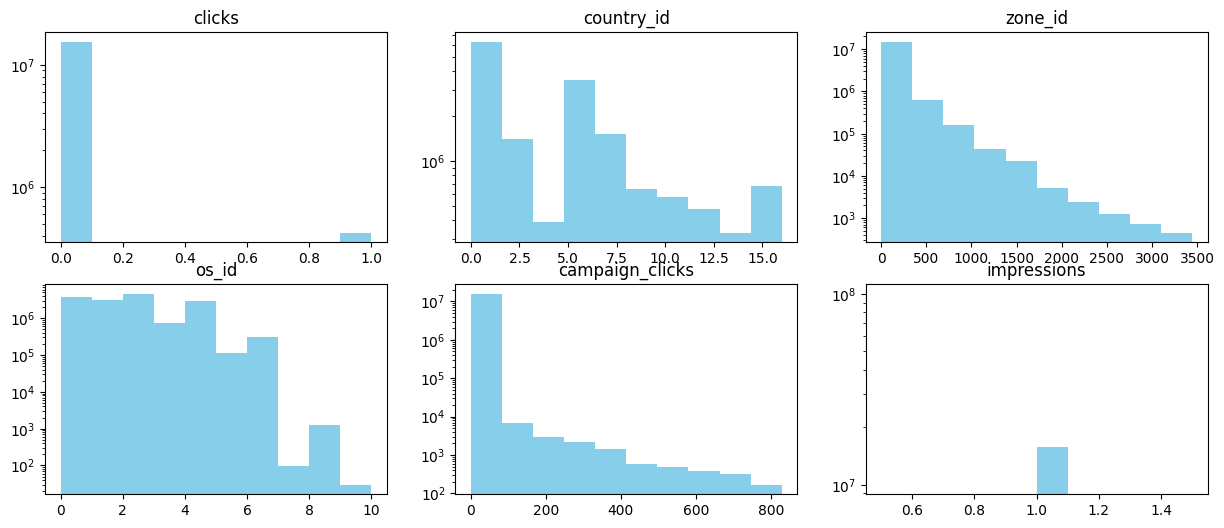

In [20]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [6]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

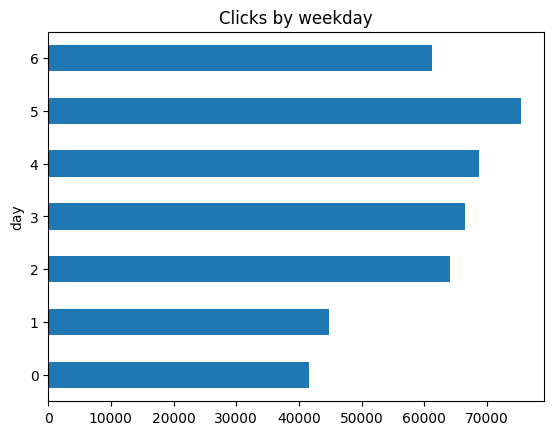

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


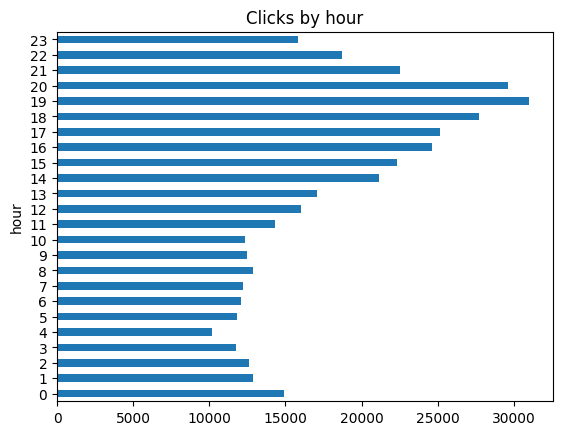

In [7]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

In [8]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [10]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [11]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.001, 0.01, 0.1, 1, 10]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            
    best_model = create_model(best_C)
    return best_model
    

In [12]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 0.1063648625916503 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.032021899550086115 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.008080989031014613 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0013102082005027667 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 7.776746888183003e-05 <= 0.0001
    2. Newton decrement 9.028626984614271e-05 <= 0.0001
  Solver did converge at loss = 0.10460058522104466.
Newton iter=1
  Check Convergence
    1. max |gradient| 0.10641962963673915 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.032123041858348154 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.008255448824912328 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0014739162147221977 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00013195021330640838 <= 0.0001
Newton iter=6
  Che

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [16]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 0.10520974411280964 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.031327756613435634 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.00784867934427151 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0013155474095837248 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 8.148622751622011e-05 <= 0.0001
    2. Newton decrement 9.445456085748602e-05 <= 0.0001
  Solver did converge at loss = 0.11116396203705046.


LogisticRegression(C=0.001, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [18]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [27]:
clf

LogisticRegression(C=0.001, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.14243308021748258
roc auc: 0.7409913049361383
f1 score: 0.15336248693460627


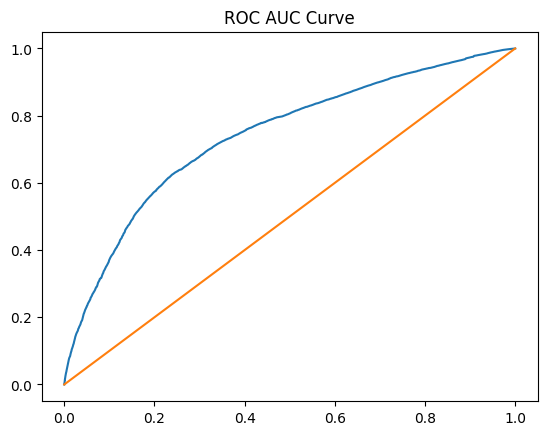

In [19]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve');

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [25]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.15303284409655607


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.